## <center>Hate Speech analyisis based on twitter data<center/>
###### <center>~  Dev Punjabi (794737), Ankur Dutta (794698)   <center/>
###### <center>MS Cognitive Systems, WS 17/18    <center/>

## 1. All the requisite libraries and functions

In [68]:
%run hate_library

In [89]:
%run common_functions
%run HAL_RF_functions
%run BoGClassfier
%matplotlib inline

## 2. The data

##### a. The raw test/train data

In [7]:
# Getting back the objects:
with open('FINALtweets_withLabels.pkl', 'rb') as f:  # Python 3: open(..., 'wb')
    finalOffense_tweet,none_tweet = pickle.load(f)

##### b. The data is divided into test and train 

In [8]:
test, train = create_test_train(finalOffense_tweet,none_tweet)

In [9]:
# Show the number of observations for the test and training dataframes
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))

Number of observations in the training data: 16333
Number of observations in the test data: 5467


## 3. The Work-flows

### I.  HAL with Random Forest

##### Step 1. Preprocessing data

In [10]:
tweet_token, test_tweet_token, train_tweet_token, test_class, train_class = modHAL_preprocess_tweets(train,test)

##### Step 2. Creating feature vectors

In [11]:
## train data
train_HAL_mat_2D = HAL_operation(train_tweet_token, tweet_token, window_size = 5)
## test data
test_HAL_mat_2D = HAL_operation(test_tweet_token, tweet_token, window_size = 5)

##### Step 3. Running the classifier (training and testing)

In [12]:
## train
RFclassifier = RF_on_HAL([tweet_token, train_class, train_HAL_mat_2D],mode="train")

In [13]:
## test
RFpredictions, all_prob, cnf_mat, acc_score = RF_on_HAL([RFclassifier, test_class, test_HAL_mat_2D],mode="test")

##### Step 4: Accuracy measures

In [14]:
## Confusion matrix
print(cnf_mat)

Predicted class     0     1
Actual class               
0                2133   560
1                 368  2406


In [15]:
## accuracy score
print(str(acc_score*100)+"%")

83.0254252789%


##### Step 4: Creating prediction plots

In [20]:
x0,y0,x1,y1 = plot_outputs(test_class,RFpredictions,all_prob)

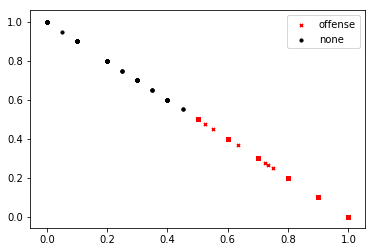

In [25]:
## the static data live plot
static_data_live_plot(x0,y0,x1,y1)

### II.  BoW with Naive Bayes and SVM

##### Step 1. Preprocessing data

In [26]:
trainList = preprocessTweet(train)
testList = preprocessTweet(test)

##### Step 2. Creating feature vectors

In [27]:
XtrainVector = createVectorX(trainList)
XtestVector = createVectorX(testList)
YtrainVector = createVectorY(trainList)
YtestVector = createVectorY(testList)


##### Step 3. Running the classifiers (SVM & Naive Bayes) 

In [40]:
pre_nb,pre_svm,nb,svm = classifyTweet(XtrainVector,YtrainVector,XtestVector,YtestVector)
prob_svm = svm.predict_proba(XtestVector)
prob_nb = nb.predict_proba(XtestVector)

Prediction Accuracy for Bag of words with MultiNominal Naive Bayes: 80.5926467898
Prediction Accuracy for Bag of words with SGDClassifier(SVM): 82.0010974941


##### Step 4: Creating matrix for plots

In [41]:
nx0, nx1, ny0, ny1 = createPlotData(pre_nb, nb, prob_nb)
sx0, sx1, sy0 , sy1 = createPlotData(pre_svm, svm, prob_svm)

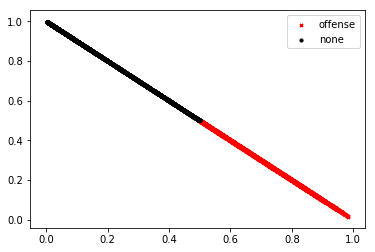

In [42]:
## naive bayes
## the static data live plot
static_data_live_plot(nx0,ny0,nx1,ny1)

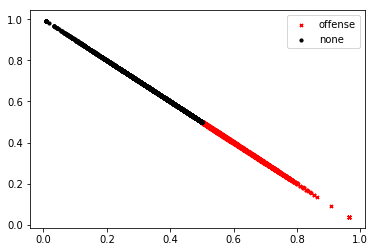

In [43]:
## naive bayes
## the static data live plot
static_data_live_plot(sx0, sy0, sx1 , sy1)

### III.  Ensemble outputs of the classifiers: Majority Voting

###### a. Running the various classifier predictions and the actual classes to create the majority voting matrix

In [32]:
vot_mat, vot_cnf_mat, vot_acc_score = voting_matrix(test_class,RFpredictions,pre_svm,pre_nb)

###### b. The voting matrix, a sneak peak

In [33]:
vot_mat.head()

,Real_Class,NB_class,SVM_class,RF_class,Voting_Class
0,0,0,1,1,1
1,0,0,0,0,0
2,0,1,1,1,1
3,0,1,0,0,0
4,0,0,0,0,0


##### c. Confusion matrix

In [34]:
print(vot_cnf_mat)

Predicted class     0     1
Actual class               
0                2112   581
1                 273  2501


###### d. The accuracy score

In [35]:
print(vot_acc_score)

0.843790012804


##### e. Understandings and inference

As, we can see implementing an ensemble of the classifiers, has improved the accuracy of the system. So, depending on the classifiers and data modelling methods, one can find a good mix to work together, to overcome one another's drawbacks and get a better result. 

#### Live tweet output

In [95]:
class StdOutListener(StreamListener):
    global tweet_token, RFclassifier,nb,svm
    tweets_data_path = './datafile.txt'
    tweets_file = io.open(tweets_data_path, "w")
    
    def on_data(self, data):
        try:
            tweet = json.loads(data)["text"]
            print("The tweet: "+str(tweet))
        except:
            print("No data")
        try:
            rf = new_tweet_RF([tweet],tweet_token,RFclassifier)
            SVM_out, N_out = BOGTweet_live(tweet,nb,svm)
            vot_list = ['offense' ,rf, SVM_out[0], N_out[0]]
            vot_list = list(pd.factorize(vot_list)[0])
            vot_list = sum(vot_list[1:])
            if(vot_list>1):
                vot_list = "none"
            else:
                vot_list = "offense"
            print("\nRF says this tweet is:"+str(rf))
            print("\nSVM says this tweet is:"+str(SVM_out[0]))
            print("\nNaive Bayes says this tweet is:"+str(N_out[0]))
            print("\nMajority voting says this tweet is:"+str(vot_list))
            stream.disconnect()
        except KeyboardInterrupt:
                print("End data flow")
                return(0)
    def on_error(self, status):
        print(status)

###### INSTRUCTION: run the cell below to see a new tweet and its hate sentiment predictions

In [98]:
l = StdOutListener()
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
stream = Stream(auth, l)
#This line filter Twitter Streams to capture data by the keywords: 'python', 'javascript', 'ruby'
stream.filter(track=['war','hate'])

The tweet: RT @ChristineArdigo: Hate your Boss? Be Glad Your Co-Workers Can Keep a Secret
https://t.co/LlGsTy8L11

#pdf1 #eartg #asmsg
https://t.co/ui…

RF says this tweet is:none

SVM says this tweet is:none

Naive Bayes says this tweet is:none

Majority voting says this tweet is:none
